# Social Computing/Social Gaming - Summer 2020

# Exercise Sheet 4: Sentiment Analysis in DotA

In this exercise we will work with data gathered from the popular MOBA *Defense of the Ancients 2* or short DotA 2, developed by Valve in 2013. If you are unfamiliar with this game, we provide a short introduction that should be enough to make you understand what the tasks demand from you:

In Dota 2, two teams of 5 players play against each other on a single map, each team trying to destroy the enemy base, also called the ancient. In order to do this, they try to kill each other, earn gold and experience by killing non player characters called creeps to gain an advantage over the enemy. In every match, players first choose from a pool of 117 different heroes which are roughly divided into 2 groups: Carries, who start out weak and become much stronger once they accumulated a sufficient amount of gold to buy items they need, and supports, who start protect the carries in the early stages of a match, but tend to become less relevant in the later stages. Every team needs a balanced hero selection in order to have a chance of winning, as too many carries will have that team face a disadvantage early on, while too many supports may cause that team to struggle to win the game even once an advantage has been secured early.

Psychologically speaking, DotA - or any MOBA for that matter - is an experiment on succesful team formation and cooperation, as 5 strangers meet each other for one match with the same goal, but usually different views on how to achieve it. Its real world equivalent would be any mash-up of people forced to work in a group, the only difference being that usually real-life situations don't involve another group working against them. 

Needless to say, the nature of the game does provoke negativity at times, and we want to try to predict it. More precisely, we want to find out whether we can infer negative player behavior from modelling the state of a game as a set of values.

The .csv files provided for you contain information from 1.500 matches played during December 2016, and are split into 5 tables: 

- chat.csv : this table contains information about what was said in the chat between teams, when it was said and which player said it. We need the 'key', 'time' and 'slot' column as we are only interested in which team the players belong to, not their identities.
- match.scsv: contains information about the game results. We only need the 'radiant_win' column from it, which tells us which team won.
- players.csv : Detailed statistics for every player. 'kills' and 'deaths' columns are needed as we will need them to determine underperforming players
- player_times.csv: Among other things the gold accumulated by every player, for every minute of a match, used to calculate the difference in gold earned between these teams.
- labels.xlsx : a sample of labeled chat used for the sentiment analysis

## Task 4.1: Your first sentiment analysis

Sentiment analysis, sometimes called opinion mining, is a method to derive information from the text that allows for a classification as neutral, positive or negative. It is a semi-supervised process, meaning that you need a small set of labeled data to train your machine learning model on in order to use it on another set of unlabeled data. Without the labeled set it would be difficult for your AI to know what exactly makes a statement positive or negative. Some of its many practical applications are the analysis of customer reviews, social media comments or survey responses.

**Note:** We will use a random forest classifier in this task.

Your task is to train a model using the labeled data, then use that model to predict the sentiments of the whole chat. Let us start with the basics:

### a) Preparation

Import the labels and split them into two arrays: the chat itself and the labels.

A label is like a review of a single message:  
-1 = negative  
 0 = neutral   
 1 = positive

In [1]:
#import libraries needed for sentiment analysis
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt

#TODO: Import "labels.xlsx" and split it into 2 arrays: chat and labels.
label_count = 450
df = pd.read_excel('labels.xlsx', header=None)

chat_data = df[0][:label_count]
chat_labels = df[1][:label_count]

### b) How to train your model

In this step you will use the chat and labels to train your random forest classifier. In order to do so, create the random forest classifier, fit it and make a prediction on the test set.

After you are done, print the accuracy score and comment on it.

**Hints:**
- When creating the classifier, use n_estimators=200, random_state=0 as arguments.
- The test should be 20% of the whole set

In [2]:
# There are some words which do not have any valuable classification information. 
# We will use 'stopwords' to get rid of them.
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Ma-
[nltk_data]     Anh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import nltk
import sklearn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing

chat_data = [str(item) for item in chat_data]
vectorizer = TfidfVectorizer(max_features=2500, min_df=3, max_df=0.8, stop_words=stopwords.words('english'))
chat_data = vectorizer.fit_transform(chat_data).toarray()

# TODO: Create the random forest classifier, fit it and make a prediction on the test set.
X_train, X_test, y_train, y_test = train_test_split(chat_data, chat_labels, test_size=0.2, random_state=0)
# y_train --> ('neutral', 244) ('negative', 90) ('positive', 26)
# y_test --> ('neutral', 56) ('negative', 30) ('positive', 4)

rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

print('\nConfusion matrix:\n', confusion_matrix(y_test, predictions))
print('\nClassification report:\n', classification_report(y_test, predictions))
print('\nAccuracy score: ', accuracy_score(y_test, predictions))


Confusion matrix:
 [[ 8 21  1]
 [ 5 51  0]
 [ 0  4  0]]

Classification report:
               precision    recall  f1-score   support

    negative       0.62      0.27      0.37        30
     neutral       0.67      0.91      0.77        56
    positive       0.00      0.00      0.00         4

    accuracy                           0.66        90
   macro avg       0.43      0.39      0.38        90
weighted avg       0.62      0.66      0.60        90


Accuracy score:  0.6555555555555556


In [4]:
y_train_classes, y_train_counts = np.unique(y_train, return_counts=True)
print('\nClass distribution for training data: ', dict(zip(y_train_classes, y_train_counts.tolist())))


Class distribution for training data:  {'negative': 90, 'neutral': 244, 'positive': 26}


**TODO: Write your observations here:**

From the class ditribution (`'negative': 90, 'neutral': 244, 'positive': 26`) of the training set and from the supports of the confusion matrix (whose $i$-th row and $j$-th column entry indicates the number of samples with true label being $i$-th class and prediced label being $j$-th class), we can see that we are dealing with an imbalanced dataset. Therefore, Accuracy Score is not a reliable performance measure in this case and we should rely on the f1-score measure shown in the classification report table.

Since our goal is to predict negativity in game chats, samples with negative label are of greatest interest. In addition, accurately predicting negative chats is absolutely important for the label assignment and analysis performed in the later subtasks of this exercises, where negativity will be used as one of the predictors for predicting whether a team will lose a game or not.

As false negatives (FN - wrongly predicting a chat not negative while it actually is) and false positives (FP - wrongly predicting a chat negative while it's not) impact equally on the correctness of the label assigning in substask 4.1.c and therefore the later analysis, the cost for FN and FP predictions would be more or less equal. This is another reason for F1-score, which is a measure of weighted average between precision and recall, to be used for evaluating the performance of the model. Unfortunately, our model with F1-score of $0.37$ for negative class will be unlikely assigning correct labels to negative chats in the next substask 4.1.c.

### c) Prediction time:

Now you can use the model to predict the sentiments for the whole chat. Import the chat and predict the labels. You will need to use `vectorizer.transform().toarray()` on your data, but **DO NOT** use `fit()` anywhere! The classifier is already fitted, fitting it again effectively erases all it has learned.

**Hint:** chat.csv includes ALL chatlines, including those that have been used in the previous steps and are already labeled. Don't label them again.

**Note:** The chat table is massive. Labelling all of it may take a while.

In [5]:
chatData = pd.read_csv("chat.csv")
unlabeled = chatData.iloc[:,1].values
# TODO:
unlabeled = [str(item) for item in unlabeled[label_count:]]
unlabeled_tfidf = vectorizer.transform(unlabeled).toarray()
predictions = rf.predict(unlabeled_tfidf)
labels, counts = np.unique(predictions, return_counts=True)

print('\nPrediction counts for unlabeled data: ', dict(zip(labels.tolist(), counts.tolist())))
print(predictions)


Prediction counts for unlabeled data:  {'negative': 3187, 'neutral': 41675, 'positive': 1457}
['neutral' 'neutral' 'neutral' ... 'neutral' 'neutral' 'neutral']


## Task 4.2: Linear regression

Linear regression is a technique that tries to find a correlation between a set of input variables x and a dependant variable y. In mathematical terms:

$$y = \alpha + \beta X + \epsilon$$

where:
- $X$ is the predictive vector, containing the (predictive) variables
- $\alpha$ and $\beta$ are the model's parameters, where $\alpha$ is the intercept/bias, $\beta$ the coefficient vector containing coefficients for each predictive variable
- and $\epsilon$ the prediction error.

Note that the assumption made is that the relationship is linear. This is a special case of polynomial regression, where we would allow for e.g. squared relationships.

Our dependant variable is the negativity in the chat. Therefore we need to convert our labels into numbers first: We will use 0 for neutral, -1 for negative and +1 for positive sentiments. This is, of course, a simplification, as not all negative statements are equally negative. But we need to acknowledge that it is simply impossible to make an accurate distinction without knowing any context. And if we knew that, there would be no point in doing this regression.

In [6]:
# Convert the labels into values
sentiments = []
for i in chat_labels:
    if i == 'positive':
        sentiments.append(1)
    elif i == 'negative':
        sentiments.append(-1)
    else:
        sentiments.append(0)

In [7]:
for i in predictions:
    if i == 'positive':
        sentiments.append(1)
    elif i == 'negative':
        sentiments.append(-1)
    elif i == 'neutral':
        sentiments.append(0)

### a) Preparation:

1. First, we need to read the csv files and group them by `match_id`.

2. We will create a dataframe containing all relevant information and each row will represent one match. An empty dataframe has already been created for you with all the columns you need to fill. Here is an explanation of what you need to put into each column:

3. Create a list of tuples called `full_chatdata`, each tuple has the following structure: label, team.

4. Create a list called `goldData` containing the gold advantage for every timestamp of a match (usually every minute).

5. Create a list called `KDratios` of kill-death ratios for each player in a match, split into two parts, one for each team, called ratiosRadiant and ratiosDire.

6. Add an additional column called `radiant_win` displaying the winning team using boolean.

**Hints:**

- you can find the labels in the chatData dataframe
- use the `slot` column to determine the team. 0 to 4 is for radiant, 5-9 is for dire
- There is a column in the match.csv file called `radiant_win` that displays true if team radiant won, false if not

In [8]:
import pandas as pd
import numpy as np

# 1. Read the csv files and group them by match id
chatData = pd.read_csv("chat.csv")
chatData = chatData.drop(['unit'],axis=1)
chatData['label'] = sentiments # We are assigning labels to the chat messages
chatData = chatData.groupby('match_id')
player_times = pd.read_csv("player_time.csv")
player_times = player_times.groupby('match_id')
match_info = pd.read_csv("match.csv")
radiant_win = match_info['radiant_win']
player_info = pd.read_csv("players.csv")
player_info = player_info[['match_id', 'kills','deaths']]
player_info = player_info.groupby('match_id')


# 2. Create the dataframe
dataframe = pd.DataFrame(columns = ['chatData','goldData', 'KDratios', 'radiant_win'])

# 3.
full_chatdata = []

for name, group in chatData:
    chat_data_line = []
    for index,row in group.iterrows():
        chat_tuple = []
        # TODO: Create a list of tuples called full_chatdata, each tuple has the following structure: label, team.
        # Hint 1: use the label column to determine the negativity/positivity of the message
        # Hint 2: use the 'slot' column to determine the team. 0 to 4 is for radiant, 5-9 is for dire.
        team = 'radiant' if 0 <= row['slot'] <= 4 else 'dire'
        chat_tuple = [row['label'], team]
        chat_data_line.append(chat_tuple)
    full_chatdata.append(chat_data_line)
        
# 4. Create a list containing the gold advantage
full_golddata =[]

for name,group in player_times:
    radiantAdv =[]
    for index, row in group.iterrows():
        radiantAdv.append((row['gold_t_0']+row['gold_t_1']+row['gold_t_2']+row['gold_t_3']+row['gold_t_4'])-
            (row['gold_t_128']+row['gold_t_129']+row['gold_t_130']+row['gold_t_131']+row['gold_t_132']))
        
    full_golddata.append(radiantAdv)


# 5.
full_playerinfo = []
for name, group in player_info:
    playerinfo = []
    for index, row in group.iterrows():
        killsdeaths = []
        killsdeaths.append(row['kills'])
        killsdeaths.append(row['deaths'])
        playerinfo.append(killsdeaths)
    full_playerinfo.append(playerinfo)

full_KDRatios = []

for row in full_playerinfo:
    KDRatios = []
    ratiosRadiant =[]
    ratiosDire = []
    for i,player in enumerate(row):
        # TODO: Create a list called [...] kill-death ratios for each player
        # Hint: For each game the kd ratios should look like the following: 
        # [[RadiantPlayer0KD, ... RadiantPlayer4KD],[DirePlayer0KD, ... DirePlayer4KD]] 
        kills = player[0]
        deaths = player[1]
        ratio = (kills / deaths) if deaths != 0 else float(kills)
        if i < 5:
            ratiosRadiant.append(ratio)
        else:
            ratiosDire.append(ratio)

    KDRatios.append(ratiosRadiant)
    KDRatios.append(ratiosDire)
    full_KDRatios.append(KDRatios)
        
# We add the newly created columns to our dataframe       
dataframe['chatData'] = full_chatdata
dataframe['goldData'] = full_golddata
dataframe['radiant_win'] = radiant_win
dataframe['KDratios'] = full_KDRatios
        
dataframe.head(5)

,chatData,goldData,KDratios,radiant_win
0,"[[0, dire], [0, radiant], [0, radiant], [-1, d...","[0, -257, -255, -567, -550, -1037, -1131, -122...","[[3.0, 4.333333333333333, 0.0, 2.0, 6.66666666...",True
1,"[[0, radiant], [0, radiant], [-1, radiant], [-...","[0, -480, -583, -964, -573, -821, -937, -1077,...","[[0.75, 0.9, 0.38461538461538464, 0.8, 0.54545...",False
2,"[[1, dire], [-1, radiant], [1, dire], [-1, rad...","[0, 273, 700, 839, 177, 522, -373, -69, -383, ...","[[0.38461538461538464, 0.5454545454545454, 1.6...",False
3,"[[0, dire], [0, radiant], [0, dire], [0, dire]...","[0, -487, -157, -178, -69, -255, -497, -404, -...","[[0.3076923076923077, 1.8461538461538463, 1.54...",False
4,"[[0, dire], [0, radiant], [0, radiant], [0, di...","[0, 333, 240, 515, 1310, 1755, 2044, 2839, 303...","[[4.0, 4.5, 0.3333333333333333, 0.25, 3.0], [0...",True


### b) Per-match analysis:

As you may have noticed, the gold variables are gathered every minute, but the chat times are irregular. We could try to group the chat into 60 second timeframes that would correspond with the gold values, but this would be too tedious. Instead, we will simplify this by looking at the game as a whole:

1. Compute the average negativity for each team by iterating over the list of tuples you created in exercise 4.2.3.

2. Then, compute the average gold advantage for each match, and add a column for the gold advantage at the end of a match. The gold advantage at the end of a match is the last value of the list.

3. Create a new column for the difference in negativity between the two teams.

4. The kill/death ratios aren't very useful in the current format. Take the lowest K/D ratio from each team and create new columns for them. The reasoning behind this is that a low K/D ratio is a sign of underperformance of a player and players who do not perform on an acceptable level are usually harassed more often.

In [9]:
from sklearn import  svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from statistics import mean


# 1. Average negativity
radiantToxicity_full = []
direToxicity_full = []

for index, row in dataframe.iterrows():
    radiantToxicity = 0
    direToxicity = 0
    # These counters keep of track of the number of messages each team wrote:
    radiantcounter = 0
    direcounter = 0
    for tup in row['chatData']:
        # TODO: Calculate each team's toxicity by summing all labels of a match.
        # Hint: Don't forget to keep count of the number of messages written by each team.
        label, team = tup
        if team == 'radiant':
            radiantcounter += 1
            if label == -1:
                radiantToxicity += label
        elif team == 'dire':
            direcounter += 1
            if label == -1:
                direToxicity += label

    radiantToxicity_full.append(radiantToxicity / radiantcounter if radiantcounter != 0 else radiantToxicity)
    direToxicity_full.append(direToxicity / direcounter if direcounter != 0 else radiantToxicity)
        
# 2. Average gold
goldAverages = []
goldEnd = []
for index, row in dataframe.iterrows():
    # TODO: Compute the average gold advantage for each match, as well as the gold advantage at the end of the match.
    # Hint: The column goldData contains a list with gold advantage per minutes.
    goldAverages.append(sum(row['goldData']) / len(row['goldData']))
    goldEnd.append(row['goldData'][-1])
    
# 3. Difference in negativity
differences = []
# TODO: Compute the difference in negativity between the 2 teams.
differences = np.array(radiantToxicity_full) - np.array(direToxicity_full)
differences = differences.tolist()

# 4. K/D ratios
worstRadiant = []
worstDire = []
for index, row in dataframe.iterrows():
    # TODO: Take the lowest K/D ratio from each team and create new columns for them.
    worstRadiant.append(min(row['KDratios'][0]))
    worstDire.append(min(row['KDratios'][1]))
    
# We add the newly created columns to our dataframe       
dataframe['toxicityR'] = radiantToxicity_full
dataframe['toxicityD'] = direToxicity_full
dataframe['goldData'] = goldAverages
dataframe['goldEnd'] = goldEnd 
dataframe['diff'] = differences
dataframe['worstKDR'] = worstRadiant
dataframe['worstKDD'] = worstDire

dataframe.head(5)

,chatData,goldData,KDratios,radiant_win,toxicityR,toxicityD,goldEnd,diff,worstKDR,worstKDD
0,"[[0, dire], [0, radiant], [0, radiant], [-1, d...",5405.651163,"[[3.0, 4.333333333333333, 0.0, 2.0, 6.66666666...",True,-0.173913,-0.214286,22365,0.040373,0.000000,0.071429
1,"[[0, radiant], [0, radiant], [-1, radiant], [-...",-7245.478261,"[[0.75, 0.9, 0.38461538461538464, 0.8, 0.54545...",False,-0.636364,-0.200000,-35698,-0.436364,0.384615,0.166667
2,"[[1, dire], [-1, radiant], [1, dire], [-1, rad...",-4928.145833,"[[0.38461538461538464, 0.5454545454545454, 1.6...",False,-0.375000,-0.190476,-26720,-0.184524,0.000000,0.833333
3,"[[0, dire], [0, radiant], [0, dire], [0, dire]...",-2074.759259,"[[0.3076923076923077, 1.8461538461538463, 1.54...",False,0.000000,-0.214286,-7919,0.214286,0.117647,0.263158
4,"[[0, dire], [0, radiant], [0, radiant], [0, di...",13510.088235,"[[4.0, 4.5, 0.3333333333333333, 0.25, 3.0], [0...",True,-0.333333,-0.500000,41280,0.166667,0.250000,0.090909


### c) A warm-up regression

Before we test our hypothesis of whether or not the state of the game influences player behavior, we will perform a linear regression with only one input variable: The gold advantage. 

You have probably wondered why we just assume that the gold values would represent the state of a game, whether a team is losing or winning. So far, this has only been a theory, and we should test it, as it would not make sense to use it as a representation for the state of the game in the actual regression model, if it wasn't representative at all.

1. Once again, split your data into a train set and test set, create a linear regression model, fit the data and print your score. Try it two times: Your dependant variable should always be `radiant_win`, your X should be the average gold advantage and the gold advantage at the end. 

2. Discuss the score you obtained! What do the results mean for the explanatory power of the gold variables?

Regression with single preditor X = goldData
0.6641129670999255


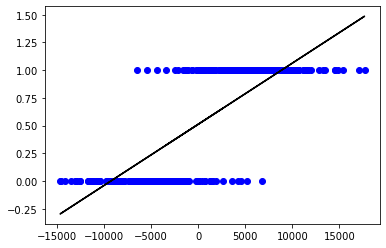

In [10]:
from sklearn import linear_model

# TODO 1:
print('Regression with single preditor X = goldData')
X = dataframe['goldData'].to_numpy().reshape(-1, 1) # TODO 
y = dataframe['radiant_win'].to_numpy() # TODO

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 
  
regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))

y_pred = regr.predict(X_test) 
plt.scatter(X_test, y_test, color ='b') 
plt.plot(X_test, y_pred, color ='k') 
  
plt.show() 

Regression with single preditor X = goldEnd
0.8654432579876028


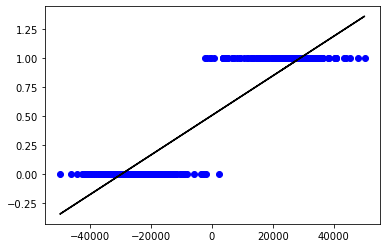

In [11]:
print('Regression with single preditor X = goldEnd')
X = dataframe['goldEnd'].to_numpy().reshape(-1, 1) # TODO 
y = dataframe['radiant_win'].to_numpy() # TODO

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 
  
regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))

y_pred = regr.predict(X_test) 
plt.scatter(X_test, y_test, color ='b') 
plt.plot(X_test, y_pred, color ='k') 
  
plt.show() 

**TODO: Write your observations here:**
From the outputs above, we have the score for the model using single predictor `goldData` is $0.644$ and the score for the model using single predictor `goldEnd` is $0.85$. From the documentation of `sklearn.linear_model.LinearRegression`, the `score()` method returns the $R^2$ value of the model. This means, $R^2_{goldData} = 0.644$ and $R^2_{goldEnd} = 0.85$. This indicates that the independent variable `goldEnd` has more explanatory power for the state of a game than `goldData` does, and therefore, `goldEnd` is better a predictor for `radiant_win` than `goldData`. These values show that, $85\%$ of the variation in `radiant_win` can be explained by the variation in the predictor `goldEnd`, while `goldData` accounts for $64.4\%$ of the variation in `radiant_win`.

However, look at the plots, we can by no means conclude that $R^2$ value indicates how well the regression line fit the data. Obviously, the relationship between the predictor `goldData` or `goldEnd` and the dependent variable `radiant_win` is not linear. To fit this data better, we need to choose a nonlinear method such as Logistic Regression.

### d) Testing our hypothesis

**1.** Finally, we can do our linear regression. This time, use the gold data, the kill/death ratios and the negativity scores.

In [12]:
# TODO 1:
# X = dataframe[dataframe.columns.difference(['chatData', 'radiant_win', 'KDratios'])].to_numpy() # TODO 
X = dataframe[['goldData', 'goldEnd', 'worstKDR', 'worstKDD']].to_numpy() # TODO 
Y = dataframe['diff'].to_numpy() # TODO
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)
print(regr.score(X,Y))

0.00569518563591731


### e) Discussion

What is the score? What does that number mean? Discuss possible reasons for this result.  
**Hint:** Take a peek at the labels.xlsx file and look at some of the most common negative words. 

**TODO: Write your observations here:**
The $R^2$ value of $0.0056951$ is low, which indicates that the set of predictors `goldData`, `goldEnd`, `worstKDR`, `worstKDD` accounts for almost none of the variation in the difference of negativity between two playing teams. In other words, there is no linear relationship between these four predictors and `diff`. However, there maybe exists a curvilinear/nonlinear relationship between them, for which we should allow higher orders of polynomial regression or the likes. The reasons might be:

- Negative chats are often short, most of the time with only 1 to 4 words, so it is hard to infer whether those chats are about the state of a game or not. 
- Negative chats do not talk about the state of a game, but rather to solely insult or offend other people for their ego